## Section 0: import and function definitions

In [134]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pygsp
from pygsp import graphs, filters
import networkx as nx
import pickle
import matplotlib.cm as cm
import pylab

In [2]:
%matplotlib inline

In [24]:
## data folders
data_folder = '../data/'
plots_folder = '../plots/'

In [48]:
# TODO: is this correct?
def build_signal(G, views):
    '''
    Given the raw counts based on page views, build the signal on the graph
    :param G:
    :param views:
    :return:
    '''
    signal_G = {}
    for node in G.nodes():
        if node in views.keys():
            try:
                signal_G[node] = views[node][1][0] / views[node][0][0]
            except IndexError:
                signal_G[node] = views[node][0][0]
            except ZeroDivisionError:
                signal_G[node] = views[node][1][0]

        else:
            signal_G[node] = 0
    return signal_G

In [119]:
def hop_map(distance_source):
    '''
    function that maps number of hops to a list of pages that can be reachable within n_hops from stan lee
    :param distance_source: the number of hops to make from source
    :return: n_hops_to_links
    '''
    hop_links = {}
    for item in distance_source:
        n_hops = distance_source[item]
        if (n_hops in hop_links):
            hop_links[n_hops].append(item)
        else:
            hop_links[n_hops] = [item]
    return hop_links


In [129]:
def assign_coordinates_colours(n_hops_to_links, signal):
    '''
    
    :param n_hops_to_links: dict that maps n_hops to the links
    :param signal: dict that maps article to their signal
    :return: the coordinates of the points and the signal
    '''
    R = list(n_hops_to_links.keys())  #radius
    T = [len(n_hops_to_links[hop]) for hop in R] # how many points per circle
    points = []
    points_signal = []
    r_init = 0
    idx = 0
    for r, t in rtpairs(R, T):
        if r == r_init:
            article = n_hops_to_links[r][idx]
            idx = idx+1
        else:
            article = n_hops_to_links[r][0]
            r_init = r
            idx = 1
        points.append(np.array([r * np.cos(t), r * np.sin(t)]))
        points_signal.append(signal[article])
    points = np.array(points)
    return points, points_signal

## Section 1: loading the signal and plotting it

In [49]:
Gnx = nx.read_gpickle(data_folder + 'G_stan_lee.gpickle')
with open(data_folder + '1_Stan Lee_signal.pkl', 'rb') as f:
     views_Gnx = pickle.load(f) 

In [50]:
signal_Gnx = build_signal(Gnx, views_Gnx)

In [52]:
source = 'Stan Lee'
distance_stan_lee = nx.shortest_path_length(Gnx, source='Stan Lee')
print('nodes are max ', max(distance_stan_lee.values()), 'hops away from ', source)

nodes are max  5 hops away from  Stan Lee


In [120]:
n_hops_to_links = hop_map(distance_stan_lee)

In [130]:
points, labels = assign_coordinates_colours(n_hops_to_links, signal_Gnx)

/Users/isabela/anaconda/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


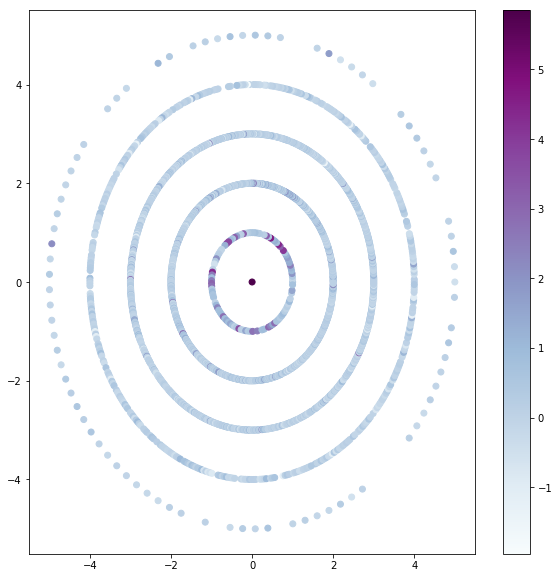

In [133]:
plt.figure(figsize=(10,10))
sc = plt.scatter(points[:,0], points[:,1], c=np.log(labels), cmap=pylab.cm.BuPu)
plt.colorbar(sc)

### Section 2: SP on the signal 

In [135]:
nx.set_node_attributes(Gnx, values= signal_Gnx, name = 'delta')

In [136]:
Gnx.node['Stan Lee']

{'delta': 347.05108962332224}

In [13]:
nodes = np.array(Gnx.nodes())
delta = nx.get_node_attributes(Gnx, 'delta')
signal = np.array([delta[n] for n in nodes])

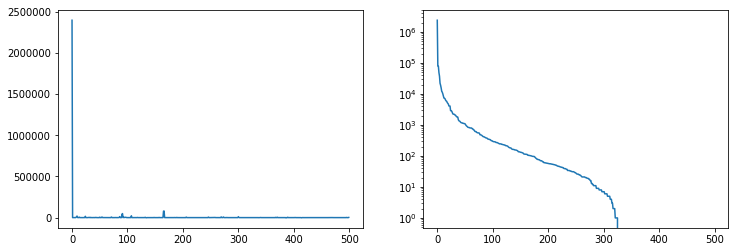

In [8]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.semilogy(sorted(signal, reverse=True))

In [8]:
# look at what pages got the highest delta
list(zip(nodes[signal>1000],signal[signal>10000]))

[('Stan Lee', 2397788),
 ('Disney Legends', 10095),
 ('Marvel Cinematic Universe', 19144),
 ('Larry Lieber', 15650),
 ('Don Heck', 12240),
 ('George W. Bush', 37743),
 ('Marvel Universe', 48962),
 ('Silver Surfer', 22206),
 ('Joe Simon', 78874),
 ('Jim Lee', 80108),
 ('DC Comics Presents', 11426)]

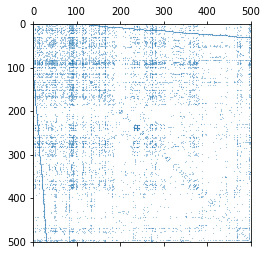

In [9]:
# make graph undirected & remove self loops
A = nx.adjacency_matrix(Gnx).todense()
A = np.logical_or(A, A.T).astype(int)
np.fill_diagonal(A, 0)
A = np.array(A)
adjacency = sparse.csr_matrix(A)

plt.spy(adjacency, markersize=0.1)

In [10]:
#sparse.csr_matrix(A)
n_nodes = A.shape[0]
D = sparse.diags(np.sum(A, axis=0))
D_inv_sq = sparse.diags(1 / np.sqrt(np.sum(A,axis=0)))
laplacian_combinatorial = D - adjacency
laplacian_normalized = sparse.eye(n_nodes) - D_inv_sq @ adjacency @ D_inv_sq.T

In [11]:
#eig_val, U = np.linalg.eigh(laplacian_normalized)
eig_val, U = sparse.linalg.eigsh(laplacian_normalized, k=20, which='SM')
U_norm = D_inv_sq @ U # renormalize for eigenmap visualizatio
eigenmap = U[:,1:3]

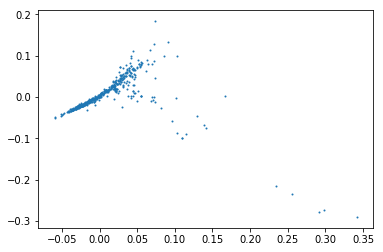

In [12]:
plt.scatter(U[:, 1], U[:, 2], s=1)

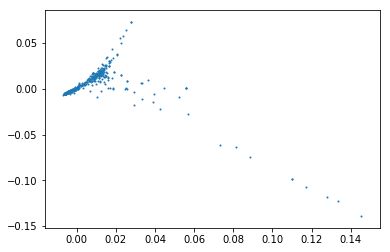

In [13]:
plt.scatter(U_norm[:, 1], U_norm[:, 2], s=1)

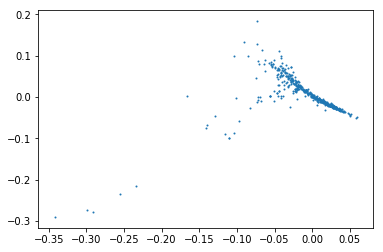

In [14]:
#G = pygsp.graphs.Graph(adjacency, lap_type='combinatorial')
G = pygsp.graphs.Graph(sparse.csr_matrix(A), lap_type='normalized')
eig_val, U = sparse.linalg.eigsh(G.L, k=20, which='SM')
plt.scatter(U[:, 1], U[:, 2], s=1)

In [15]:
#G.set_coordinates(kind='spring')
G.set_coordinates(U[:,1:3])

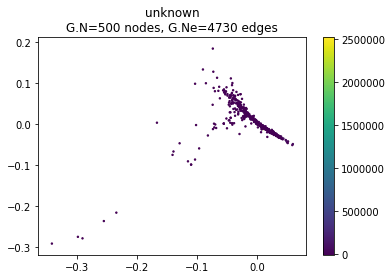

In [16]:
G.plot_signal(signal, vertex_size=2, show_edges=False)

In [17]:
eigenval_comb, eigen_vec_comb = np.linalg.eigh(laplacian_combinatorial.toarray())

In [18]:
e, U = eigenval_comb, eigen_vec_comb

def GFT(x):
    return  np.matmul(U.T,x) # U.T= U^-1 because orthonormal 

def iGFT(x):
    return np.matmul(U,x) 

def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    g = 1/(1 + t*e)
    return g

def rectangle_kernel(e, l_min, l_max):
    cond = np.logical_and(e >= l_min, e <= l_max)
    return np.where(cond, 1, 0)

def graph_filter(x, kernel, **kwargs):
    e = eigenval_comb
    g = kernel(e, **kwargs)
    return iGFT(np.matmul(np.diag(g),GFT(x)))

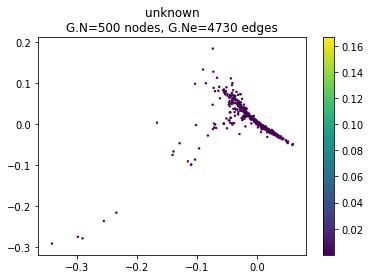

In [19]:
dirac = np.zeros(n_nodes);
dirac[nodes=='Stan Lee'] = 1;
x = graph_filter(dirac, heat_kernel, t=0.01)
G.plot_signal(x, vertex_size=2, show_edges=False)

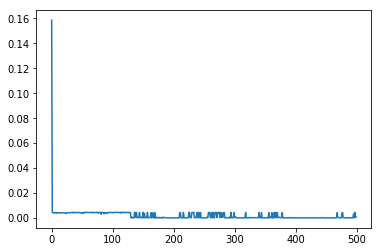

In [20]:
plt.plot(x)